In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from rl_env.trading_env import BondFuturesTradingEnv

from stable_baselines.sac.policies import LnMlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import SAC

We are assuming that the trade cost is 2% of the whole amount traded

In [ ]:
n_timesteps = 100000

env = DummyVecEnv([lambda: BondFuturesTradingEnv(validation=False)])
policy_kwargs = dict(layers=[32, 32])

model = SAC(LnMlpPolicy, env, verbose=0, gamma=0.99, tensorboard_log='logs/', full_tensorboard_log=False,
            train_freq=1, batch_size=64, tau=0.005, policy_kwargs=policy_kwargs, buffer_size=50000,
            learning_starts=5000)

model.learn(total_timesteps=n_timesteps)
model.save('models/SAC.pkl')

W1013 23:16:10.650338 13052 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\tf_util.py:98: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1013 23:16:10.651339 13052 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\tf_util.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1013 23:16:10.658312 13052 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\sac\sac.py:150: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1013 23:16:10.659311 13052 deprecation_wrapper.py:119] From C:\Users\Dema\Anaconda3\envs\SeasonalsSubmission\lib\site-packages\stable_baselines\common\input.py:25: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W

#### Results on the training enviroment

------------------------------
Total % Return:        3037.127%
Total % Annual Return: 1678.412%
Maximum % Drawdown:    -96.812%
Sharpe Ratio:          3.819
------------------------------


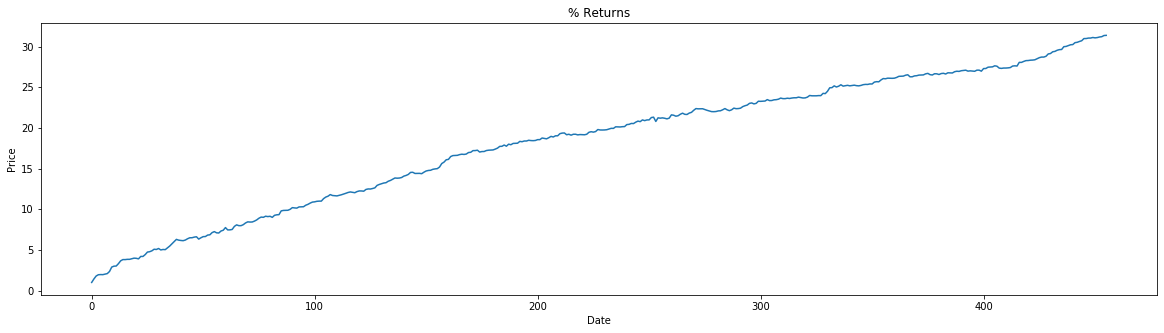

In [14]:
val_env = BondFuturesTradingEnv(validation=False)
obs = val_env.reset()
done = False
model = SAC.load('models/SAC.pkl')
    
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = val_env.step(action)
    
val_env.render()

#### Results on the validation data

------------------------------
Total % Return:        163.096%
Total % Annual Return: 360.529%
Maximum % Drawdown:    -78.858%
Sharpe Ratio:          3.179
------------------------------


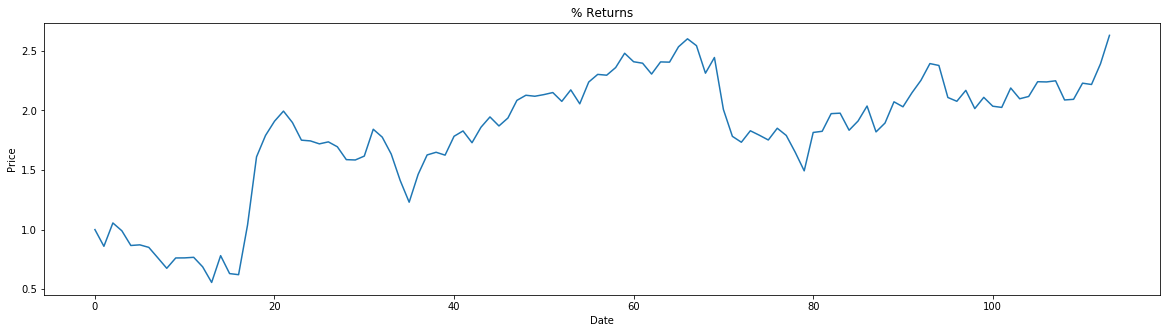

In [15]:
val_env = BondFuturesTradingEnv(validation=True)
obs = val_env.reset()
done = False
model = SAC.load('models/SAC.pkl')
    
while not done:
    action, _states = model.predict(obs)
    obs, rewards, done, info = val_env.step(action)
    
val_env.render()